In [1]:
#импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import ensemble
# from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna

import warnings

%matplotlib inline
plt.style.use('seaborn')

# Загрузка данных

In [2]:
data = pd.read_csv('data/_train_sem09 (1).csv')
data

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


In [3]:
RANDOM_STATE = 42
MAX_ITER = 50
CV = 5

warnings.filterwarnings('ignore')

**Проверим данные на сбалансированность**

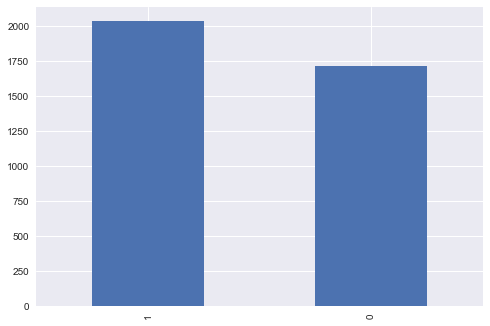

In [4]:
data['Activity'].value_counts().plot(kind='bar');

Дисбаланс выборки отсутсвует

# Подготовка данных к обучению

**Создаем матрицу наблюдений X и вектор ответов y**

In [5]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

**Разделяем выборку на тренировочную и тестовую в соотношении 80/20**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

# Фиксация метрик без дополнительной настройки модели.

**Логистическая регрессия:**

In [7]:
log_reg = linear_model.LogisticRegression(max_iter=MAX_ITER)

%time log_reg.fit(X_train, y_train)

y_train_pred_lr = log_reg.predict(X_train)
print(f'f1_score на обучающей выборке (без настроек гиперпараметров): {f1_score(y_train, y_train_pred_lr).round(2)}')

y_test_pred_lr = log_reg.predict(X_test)
print(f'f1_score на тестовой выборке (без настроек гиперпараметров): {f1_score(y_test, y_test_pred_lr).round(2)}')

CPU times: total: 2.77 s
Wall time: 2.83 s
f1_score на обучающей выборке (без настроек гиперпараметров): 0.88
f1_score на тестовой выборке (без настроек гиперпараметров): 0.79


**Случайный лес**

In [8]:
rf = ensemble.RandomForestClassifier(random_state=RANDOM_STATE)

%time rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
print(f'f1_score на обучающей выборке (без настроек гиперпараметров): {f1_score(y_train, y_train_pred_rf).round(2)}')

y_test_pred_rf = rf.predict(X_test)
print(f'f1_score на тестовой выборке (без настроек гиперпараметров): {f1_score(y_test, y_test_pred_rf).round(2)}')

CPU times: total: 2.42 s
Wall time: 2.45 s
f1_score на обучающей выборке (без настроек гиперпараметров): 1.0
f1_score на тестовой выборке (без настроек гиперпараметров): 0.83


# Подбор гиперпараметров

## GridSearchCV

**Логистическая регрессия**

In [9]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'saga'],
              }

grid_search = GridSearchCV(
    estimator = linear_model.LogisticRegression(
        random_state = RANDOM_STATE,
        max_iter = MAX_ITER
    ), 
    param_grid = param_grid, 
    cv = CV, 
    n_jobs = -1
)

%time grid_search.fit(X_train, y_train)

y_train_pred_lr = log_reg.predict(X_train)
print(f'f1_score на обучающей выборке: {f1_score(y_train, y_train_pred_lr).round(2)}')

y_test_pred_lr = log_reg.predict(X_test)
print(f'f1_score на тестовой выборке: {f1_score(y_test, y_test_pred_lr).round(2)}')

print(f"Наилучшие значения гиперпараметров: {grid_search.best_params_}")

CPU times: total: 5.55 s
Wall time: 39.5 s
f1_score на обучающей выборке: 0.88
f1_score на тестовой выборке: 0.79
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}


Метрика не изменилась, попробуем улучшить её добавлением силы регуляризации

In [10]:
param_grid = {'penalty': ['l2'] ,
              'solver': ['lbfgs'],
              'C': np.linspace(0.01, 1, 10)
              }

grid_search = GridSearchCV(
    estimator = linear_model.LogisticRegression(
        random_state = RANDOM_STATE,
        max_iter = MAX_ITER
    ), 
    param_grid = param_grid, 
    cv = CV, 
    n_jobs = -1
)

%time grid_search.fit(X_train, y_train)

y_train_pred_lr = log_reg.predict(X_train)
print(f'f1_score на обучающей выборке: {f1_score(y_train, y_train_pred_lr).round(2)}')

y_test_pred_lr = log_reg.predict(X_test)
print(f'f1_score на тестовой выборке: {f1_score(y_test, y_test_pred_lr).round(2)}')

print(f"Наилучшие значения гиперпараметров: {grid_search.best_params_}")

CPU times: total: 3.11 s
Wall time: 1min 12s
f1_score на обучающей выборке: 0.88
f1_score на тестовой выборке: 0.79
Наилучшие значения гиперпараметров: {'C': 0.12, 'penalty': 'l2', 'solver': 'lbfgs'}


In [11]:
print(f"Наилучшая модель:\n{grid_search.best_estimator_}")

Наилучшая модель:
LogisticRegression(C=0.12, max_iter=50, random_state=42)


**Случайный лес**

In [12]:
param_grid = {'n_estimators': list(range(50, 200, 50)),
              'min_samples_leaf': [2, 5],
              'max_depth': list(np.linspace(10, 20, 5, dtype=int))
              }

grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RANDOM_STATE), 
    param_grid=param_grid, 
    cv=CV, 
    n_jobs = -1
)  

%time grid_search_rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
print(f'f1_score на обучающей выборке: {f1_score(y_train, y_train_pred_rf).round(2)}')

y_test_pred_rf = rf.predict(X_test)
print(f'f1_score на тестовой выборке: {f1_score(y_test, y_test_pred_rf).round(2)}')

print(f"Наилучшие значения гиперпараметров: {grid_search_rf.best_params_}")

CPU times: total: 3.52 s
Wall time: 1min 51s
f1_score на обучающей выборке: 1.0
f1_score на тестовой выборке: 0.83
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 100}


## RandomizedSearchCV

**Логистическая регрессия**

In [13]:
param_distributions = {'penalty': ['l2'] ,
                       'solver': ['lbfgs', 'sag'],
                       'C': list(np.linspace(0.01, 1, 10))}

random_search = RandomizedSearchCV(
        estimator=linear_model.LogisticRegression(
        random_state=RANDOM_STATE, 
        max_iter=MAX_ITER), 
    param_distributions=param_distributions, 
    cv=CV, 
    n_iter=10, 
    n_jobs=-1
)  

%time random_search.fit(X_train, y_train)

y_train_pred_lr = log_reg.predict(X_train)
print(f'f1_score на обучающей выборке: {f1_score(y_train, y_train_pred_lr).round(2)}')

y_test_pred_lr = log_reg.predict(X_test)
print(f'f1_score на тестовой выборке: {f1_score(y_test, y_test_pred_lr).round(2)}')

print(f"Наилучшие значения гиперпараметров: {random_search.best_params_}")

CPU times: total: 3.69 s
Wall time: 1min 15s
f1_score на обучающей выборке: 0.88
f1_score на тестовой выборке: 0.79
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.23}


**Случайный лес**

In [14]:
param_distributions = {'n_estimators': list(range(50, 300, 50)),
              'min_samples_leaf': [2, 5, 7],
              'max_depth': list(np.linspace(10, 30, 5, dtype=int))}
            
random_search_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RANDOM_STATE), 
    param_distributions=param_distributions, 
    cv=CV,
    n_iter=10, 
    n_jobs=-1
) 

%time random_search_rf.fit(X_train, y_train)

y_train_pred_rf = log_reg.predict(X_train)
print(f'f1_score на обучающей выборке: {f1_score(y_train, y_train_pred_rf).round(2)}')

y_test_pred_rf = log_reg.predict(X_test)
print(f'f1_score на тестовой выборке: {f1_score(y_test, y_test_pred_rf).round(2)}')

print(f"Наилучшие значения гиперпараметров: {random_search_rf.best_params_}")

CPU times: total: 6.23 s
Wall time: 1min 10s
f1_score на обучающей выборке: 0.88
f1_score на тестовой выборке: 0.79
Наилучшие значения гиперпараметров: {'n_estimators': 250, 'min_samples_leaf': 2, 'max_depth': 30}


Попробуем улучшить метрику

In [15]:
param_distributions = {'n_estimators': list(range(50, 500, 10)),
              'min_samples_leaf': list(np.linspace(2, 10, 7, dtype=int)),
              'max_depth': list(np.linspace(10, 40, 5, dtype=int)),
              'criterion': ['gini', 'entropy', 'log_loss']}
            
random_search_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RANDOM_STATE), 
    param_distributions=param_distributions, 
    cv=CV,
    n_iter=20, 
    n_jobs=-1
) 

%time random_search_rf.fit(X_train, y_train)

y_train_pred_rf = log_reg.predict(X_train)
print(f'f1_score на обучающей выборке: {f1_score(y_train, y_train_pred_rf).round(2)}')

y_test_pred_rf = log_reg.predict(X_test)
print(f'f1_score на тестовой выборке: {f1_score(y_test, y_test_pred_rf).round(2)}')

print(f"Наилучшие значения гиперпараметров: {random_search_rf.best_params_}")

CPU times: total: 7.3 s
Wall time: 3min 22s
f1_score на обучающей выборке: 0.88
f1_score на тестовой выборке: 0.79
Наилучшие значения гиперпараметров: {'n_estimators': 260, 'min_samples_leaf': 2, 'max_depth': 17, 'criterion': 'log_loss'}


## Hyperopt

**Логистическая регрессия**

In [16]:
penaltys = ['l2', 'none']
solvers = ['lbfgs', 'sag', 'saga']

space={'penalty': hp.choice('penalty', penaltys),
       'solver' : hp.choice('solver', solvers),
       'C': hp.uniform('C', 0.01, 1)
      }

In [17]:
def hyperopt_lr(params, cv=CV, X=X_train, y=y_train, random_state=RANDOM_STATE):
    
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': params['C']
              }

    model = linear_model.LogisticRegression(**params, random_state=RANDOM_STATE, max_iter=MAX_ITER)

    model.fit(X, y)
    
    # score = f1_score(y, model.predict(X))
    score = cross_val_score(model, X, y, cv=CV, scoring="f1", n_jobs=-1).mean()

    return -score

In [18]:
%%time

trials = Trials()

best=fmin(hyperopt_lr,
          space=space,
          algo=tpe.suggest,
          max_evals=10,
          trials=trials,
          rstate=np.random.default_rng(RANDOM_STATE)
         )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.68s/trial, best loss: -0.7860656860417223]
CPU times: total: 35.8 s
Wall time: 2min 6s


In [19]:
model = linear_model.LogisticRegression(
    random_state=RANDOM_STATE, 
    max_iter=MAX_ITER,
    penalty=penaltys[best['penalty']],
    solver=solvers[best['solver']],
    C=best['C']
)

model.fit(X_train, y_train)

y_train_pred_lr = model.predict(X_train)
print(f'f1_score на обучающей выборке: {f1_score(y_train, y_train_pred_lr).round(2)}')

y_test_pred_lr = model.predict(X_test)
print(f'f1_score на тестовой выборке: {f1_score(y_test, y_test_pred_lr).round(2)}')

print(f"Наилучшие значения гиперпараметров: {best}")

f1_score на обучающей выборке: 0.85
f1_score на тестовой выборке: 0.79
Наилучшие значения гиперпараметров: {'C': 0.08292441519601887, 'penalty': 0, 'solver': 0}


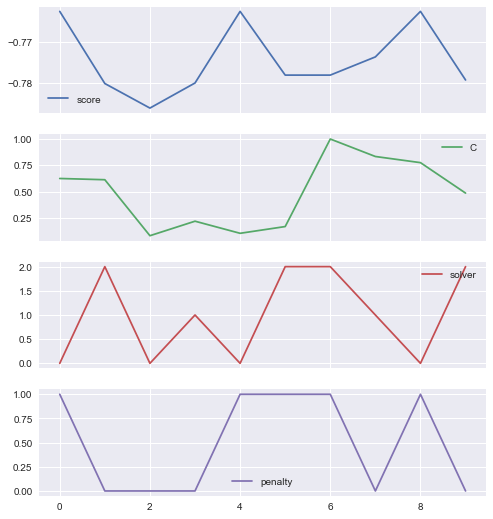

In [20]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0],
                      x['misc']['vals']['solver'][0],
                      x['misc']['vals']['penalty'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'C', 'solver', 'penalty'])

tpe_results_df.plot(subplots=True,figsize=(8, 9));

**Случайный лес**

In [21]:
criterions = ['gini', 'entropy', 'log_loss']

space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1),
       'criterion': hp.choice('criterion', criterions)
      }

In [22]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf']), 
             'criterion': params['criterion']
              }

    model = ensemble.RandomForestClassifier(**params, random_state=RANDOM_STATE)
    
    model.fit(X, y)
    
    # score = metrics.f1_score(y, model.predict(X))
    score = cross_val_score(model, X, y, cv=CV, scoring="f1", n_jobs=-1).mean()
    
    return -score

In [23]:
%time

trials = Trials()

best=fmin(hyperopt_rf,
          space=space,
          algo=tpe.suggest,
          max_evals=10,
          trials=trials,
          rstate=np.random.default_rng(RANDOM_STATE)
         )

print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:38<00:00,  9.86s/trial, best loss: -0.8107783775263364]
Наилучшие значения гиперпараметров {'criterion': 1, 'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 115.0}


In [24]:
model = ensemble.RandomForestClassifier(
    random_state=RANDOM_STATE, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf']),
    criterion=criterions[best['criterion']]
)

model.fit(X_train, y_train)

y_train_pred_rf = model.predict(X_train)
print(f'f1_score на обучающей выборке: {f1_score(y_train, y_train_pred_rf).round(2)}')

y_test_pred_rf = model.predict(X_test)
print(f'f1_score на тестовой выборке: {f1_score(y_test, y_test_pred_rf).round(2)}')

print(f"Наилучшие значения гиперпараметров: {best}")

f1_score на обучающей выборке: 0.98
f1_score на тестовой выборке: 0.83
Наилучшие значения гиперпараметров: {'criterion': 1, 'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 115.0}


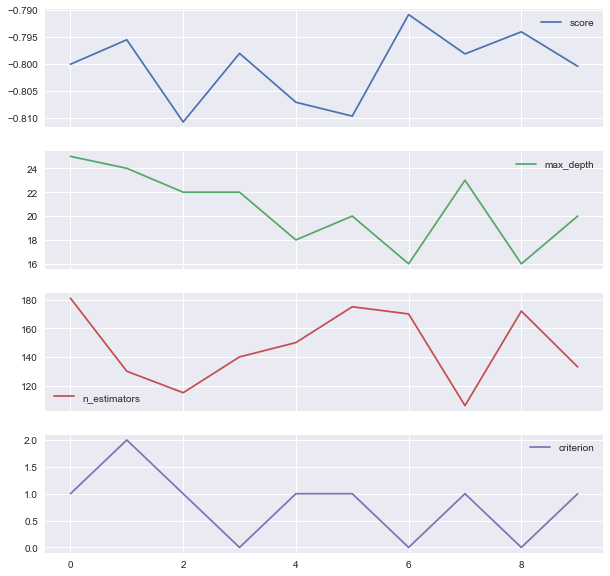

In [25]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['criterion'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators', 'criterion'])

tpe_results_df.plot(subplots=True,figsize=(10, 10));

## Optuna

**Логистическая регрессия**

In [26]:
def optuna_lr(trial):
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'saga'])
  C = trial.suggest_loguniform('C', 1e-2, 1)

  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=RANDOM_STATE)

  model.fit(X_train, y_train)
  
  # score = metrics.f1_score(y_train, model.predict(X_train))
  score = cross_val_score(model, X, y, cv=CV, scoring="f1", n_jobs=-1).mean()

  return score

In [27]:
%%time

study = optuna.create_study(study_name="LogisticRegression", direction="maximize")

study.optimize(optuna_lr, n_trials=10)

[I 2022-09-19 11:43:10,630] A new study created in memory with name: LogisticRegression
[I 2022-09-19 11:43:42,096] Trial 0 finished with value: 0.7708390231147334 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.040374659722002174}. Best is trial 0 with value: 0.7708390231147334.
[I 2022-09-19 11:44:14,835] Trial 1 finished with value: 0.7833321599991047 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.1333554981697506}. Best is trial 1 with value: 0.7833321599991047.
[I 2022-09-19 11:44:48,481] Trial 2 finished with value: 0.7778286111586445 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.7231842778549373}. Best is trial 1 with value: 0.7833321599991047.
[I 2022-09-19 11:45:12,036] Trial 3 finished with value: 0.7583522396374635 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.11275046623787136}. Best is trial 1 with value: 0.7833321599991047.
[I 2022-09-19 11:45:45,442] Trial 4 finished with value: 0.790672472410397 and parameters: {'pena

CPU times: total: 1min 14s
Wall time: 5min 20s


In [28]:
model = linear_model.LogisticRegression(**study.best_params, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

y_train_pred_lr = model.predict(X_train)
print(f'f1_score на обучающей выборке: {f1_score(y_train, y_train_pred_lr).round(2)}')

y_test_pred_lr = model.predict(X_test)
print(f'f1_score на тестовой выборке: {f1_score(y_test, y_test_pred_lr).round(2)}')

print(f"Наилучшие значения гиперпараметров {study.best_params}")

f1_score на обучающей выборке: 0.83
f1_score на тестовой выборке: 0.8
Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'sag', 'C': 0.026146101008062875}


**Случайный лес**

In [29]:
def optuna_rf(trial):
    
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=RANDOM_STATE)

  model.fit(X_train, y_train)
  
  # score = metrics.f1_score(y_train, model.predict(X_train))
  score = cross_val_score(model, X, y, cv=CV, scoring="f1", n_jobs=-1).mean()

  return score

In [30]:
%%time

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=10)

[I 2022-09-19 11:48:39,094] A new study created in memory with name: RandomForestClassifier
[I 2022-09-19 11:48:47,711] Trial 0 finished with value: 0.7908315902671662 and parameters: {'n_estimators': 157, 'max_depth': 10, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7908315902671662.
[I 2022-09-19 11:48:55,820] Trial 1 finished with value: 0.8115298891894364 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_leaf': 2, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.8115298891894364.
[I 2022-09-19 11:49:03,173] Trial 2 finished with value: 0.7964904464338762 and parameters: {'n_estimators': 101, 'max_depth': 12, 'min_samples_leaf': 6, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.8115298891894364.
[I 2022-09-19 11:49:12,695] Trial 3 finished with value: 0.806798829421315 and parameters: {'n_estimators': 114, 'max_depth': 18, 'min_samples_leaf': 6, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.811529889189436

CPU times: total: 25.8 s
Wall time: 1min 46s


In [31]:
model = ensemble.RandomForestClassifier(**study.best_params, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

y_train_pred_rf = model.predict(X_train)
print(f'f1_score на обучающей выборке: {f1_score(y_train, y_train_pred_rf).round(2)}')

y_test_pred_rf = model.predict(X_test)
print(f'f1_score на тестовой выборке: {f1_score(y_test, y_test_pred_rf).round(2)}')

print(f"Наилучшие значения гиперпараметров {study.best_params}")

f1_score на обучающей выборке: 0.99
f1_score на тестовой выборке: 0.82
Наилучшие значения гиперпараметров {'n_estimators': 108, 'max_depth': 29, 'min_samples_leaf': 2, 'criterion': 'gini'}
